NB: run `unpack_maalfrid.sh` before running this notebook!

In [2]:
# builds datastructure of translation pairs

pairs = {
    "en-nb": {"en": [], "nb": []},
    "en-nn": {"en": [], "nn": []},
    "nb-nn": {"nb": [], "nn": []}
}

import os
from translate.storage.tmx import tmxfile

for root, dirs, filenames in os.walk("maalfrid"):
    if "-" in root: # in a subfolder with tmx pair files
        folder = root.split("/")[1]
        sourcelang, targetlang = folder.split("-")
        
        
        for filename in filenames:
            with open(root + "/"+ filename, "rb") as f:
                tmx_file = tmxfile(f, sourcelang, targetlang)
            
            for node in tmx_file.unit_iter():
                pairs[folder][sourcelang].append(node.source)
                pairs[folder][targetlang].append(node.target)

In [3]:
#copied from https://tfhub.dev/google/LaBSE/2

import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text as text  # Needed for loading universal-sentence-encoder-cmlm/multilingual-preprocess
import numpy as np

2023-10-27 13:13:44.273198: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-27 13:13:44.435159: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-27 13:13:44.435767: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-27 13:13:46.136085: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# import preprocessor and LaBSE model
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/LaBSE/2")

2023-10-27 13:13:48.211829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-10-27 13:13:48.216079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-10-27 13:13:48.216756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-10-27 13:13:48.219171: I tensorflow/core/

2023-10-27 13:13:52.873468: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1539542016 exceeds 10% of free system memory.


In [6]:
%%time
from scipy.spatial.distance import cityblock
numberofsentencepairs = 9

for pair in pairs:

    sourcelang, targetlang = pairs[pair].keys()

    sourcesentences = pairs[pair][sourcelang][:numberofsentencepairs]
    targetsentences = pairs[pair][targetlang][:numberofsentencepairs]
    source_embeds = encoder(preprocessor(sourcesentences))["default"]
    target_embeds = encoder(preprocessor(targetsentences))["default"]

    euclideandistances = []    
    manhattandistances = []
    for i in range(0, len(source_embeds)):
        manhattandistances.append(cityblock(source_embeds[i], target_embeds[i]))
        euclideandistances.append(np.linalg.norm(source_embeds[i] - target_embeds[i]))
    
    
    print("Average manhattan distance for " + pair + ":")
    print(sum(manhattandistances)/len(manhattandistances))
    print("Average euclidean distance for " + pair + ":")
    print(sum(euclideandistances)/len(euclideandistances))
    indexworst = euclideandistances.index(max(euclideandistances))
    indexbest = euclideandistances.index(min(euclideandistances))
    break

    #print("Most distant sentence pair with distance of " + str(euclideandistances[indexworst]) + ":")
    #print(sourcesentences[indexworst], "<->", targetsentences[indexworst])
    #print("Closest sentence pair with distance of " + str(euclideandistances[indexbest]) + ":")
    #print(sourcesentences[indexbest], "<->", targetsentences[indexbest])

    print()

Average manhattan distance for en-nb:
149.29032558865018
Average euclidean distance for en-nb:
6.699094401465522
CPU times: user 14.6 s, sys: 330 ms, total: 14.9 s
Wall time: 3.37 s


In [41]:
%%time

from scipy.spatial.distance import cityblock
numberofsentencepairs = 30

iterations = 1
offset = 50000

for pair in pairs:
    if pair != "en-nb": 
        continue
    print(pair)
    sourcelang, targetlang = pairs[pair].keys()
    avgsman = []
    avgseuc = []

    for it in range(0, iterations):
        start = numberofsentencepairs*it
        end = numberofsentencepairs*(it+1) - 1
        
        start += offset
        end += offset
        print(start, end)
        sourcesentences = pairs[pair][sourcelang][start:end]
        targetsentences = pairs[pair][targetlang][start:end]
        print(sourcesentences[0])
        print(targetsentences[0])

        source_embeds = encoder(preprocessor(sourcesentences))["default"]
        target_embeds = encoder(preprocessor(targetsentences))["default"]

        euclideandistances = []    
        manhattandistances = []
        for i in range(0, len(source_embeds)):
            manhattandistances.append(cityblock(source_embeds[i], target_embeds[i]))
            euclideandistances.append(np.linalg.norm(source_embeds[i] - target_embeds[i]))
        
        avgsman.append(sum(manhattandistances)/len(manhattandistances))
        avgseuc.append(sum(euclideandistances)/len(euclideandistances))
        
        rankeddistances = []
        for i in range(0, len(euclideandistances)):
            rankeddistances.append({"index": i, 
                                    "distance": manhattandistances[i], 
                                    "sentence_source": sourcesentences[i], 
                                    "sentence_target": targetsentences[i]
                                   })
        sorted_distances = sorted(rankeddistances[:30], key=lambda x: x['distance'])

        for e in sorted_distances:
            print("Distance:", e["distance"])
            print(e["sentence_source"])
            print(e["sentence_target"])
            print()
        
        
    print(avgsman)
    print("Average manhattan distance for " + pair + ":")
    print(sum(avgsman)/len(avgsman))
    print("Average euclidean distance for " + pair + ":")
    print(sum(avgseuc)/len(avgseuc))
    
    #indexworst = euclideandistances.index(max(euclideandistances))
    #indexbest = euclideandistances.index(min(euclideandistances))

    #print("Most distant sentence pair with distance of " + str(euclideandistances[indexworst]) + ":")
    #print(sourcesentences[indexworst], " <-> ", targetsentences[indexworst])
    #print("Closest sentence pair with distance of " + str(euclideandistances[indexbest]) + ":")
    #print(sourcesentences[indexbest], " <-> ", targetsentences[indexbest])

    print()

en-nb
50000 50029
Besides offering background and recommendations for operators’ own professional development and training, the report could be informative for leadership at Acute Medical Communications Central (AMK central), especially for the design and implementation of training and evaluation programs.
I tillegg til å gi bakgrunn og anbefalinger til operatørenes egen trening og faglige utvikling, kan rapporten også være nyttig for ledelsen ved Akuttmedisinsk kommunikasjonssentral (AMK-sentralen), spesielt om hvordan man kan utforme og gjennomføre trenings- og evalueringsprogrammer.
Distance: 121.952774
In the period 2015-2017, almost 70% of men and almost all women responded that they only used portion snus.
I perioden 2015-2017 svarte nesten 70 % av mennene og nesten alle kvinnene at de kun brukte porsjonssnus.

Distance: 124.576645
Survival and symptom relief may improve with gemcitabine + nab‐paclitaxel compared to gemcitabine alone, but may also lead to more side effect.
Mulige

In [46]:
from scipy.spatial.distance import cityblock

triplets = []
triplets.append({
    "english": "After 1958, measurements using sonar have been taken sporadically from submarines, and as of the 1990s, also from permanent installations.",
    "nb_original": "Siden 1958 har det vært gjort sporadiske målinger med sonar, som måler isen fra undersiden ved hjelp av ubåt og fra 1990-tallet fra faste installasjoner.",
    "nb_rewritten": "Siden 1958, målinger med sonar har det vært gjort sporadiske ved hjelp av ubåter som måler isen fra undersiden, og fra 1990-tallet, fra faste installasjoner"
})
triplets.append({
    "english": "All parts of the cryosphere are sensitive to climate change, and they all play important roles in the global climate system.",
    "nb_rewritten": "alle komponenter Kryosfærens er følsomme for klimaendringer, og alle har en betydelig rolle i det globale klimasystemet.",
    "nb_original": "Kryosfærens komponenter er alle følsomme for klimaendringer, og alle har en betydelig rolle i det globale klimasystemet."
})
triplets.append({
    "english": "His areas of expertise are cybernetics, autonomics, artificial intelligence, strategy, organisational development, management and innovation.",
    "nb_rewritten": "hans Fagområdene er kybernetikk, autonomi, kunstig intelligens, strategi, organisasjonsutvikling, ledelse og innovasjon.",
    "nb_original": "Fagområdene hans er kybernetikk, autonomi, kunstig intelligens, strategi, organisasjonsutvikling, ledelse og innovasjon."
})

triplets.append({
    "english": "presents a cutting-edge assessment of NATO's collective defence strategies in the immediate aftermath of the July 2016 NATO Warsaw Summit.",
    "nb_rewritten": "presenterer en banebrytende vurdering av NATOs kollektive forsvarsstrategier i kjølvannet av i juli 2016 NATOs Warszawa i toppmøte.",
    "nb_original": "presenterer en banebrytende vurdering av NATOs kollektive forsvarsstrategier i kjølvannet av NATOs toppmøte i Warszawa i juli 2016."
})
triplets.append({
    "english": "There is no necessary link between living in another country than one’s home country and having an offshore account.",
    "nb_rewritten": "Det ikke noen nødvendig sammenheng eksisterer mellom det å bo utenlands og det å ha en offshore konto.",
    "nb_original": "Det eksisterer ikke noen nødvendig sammenheng mellom det å bo utenlands og det å ha en konto offshore."
})

triplets.append({
    "english": "While the European integration process with the European Union (EU) is by far the most extensive example of regional integration, similar processes has been launched both in Africa (African Union), Asia (ASEAN)",
    "nb_rewritten": "det europeiske integrasjonsprosjektet EU er nok Det mest kjente eksemplet her til lands, men liknende prosesser har skjedd både i Afrika (AU) og Asia (ASEAN)",
    "nb_original": "Det mest kjente eksemplet her til lands er nok det europeiske integrasjonsprosjektet, EU, men liknende prosesser har skjedd både i Afrika (AU) og Asia (ASEAN)"
})

triplets.append({
    "english": "In 2021 the National Museum has curatorial responsibility for of the Nordic pavilion at the Venice Biennale of Architecture.",
    "nb_rewritten": "i 2021 Nasjonalmuseet har kurator- og prosjektlederansvar for den nordiske paviljsongen under Venezia arkitekturbiennalen i",
    "nb_original": "Nasjonalmuseet har i 2021 kurator- og prosjektlederansvar for den nordiske paviljongen under arkitekturbiennalen i Venezia."
})

triplets.append({
    "english": "This is yet another argument for the importance of changing the name of the KIF Committee from women to gender.”",
    "nb_rewritten": "Det er et enda argument for er viktig navneendringen til at Kif fra kvinner til kjønn",
    "nb_original":"Det er enda et argument for at navneendringen til Kif – fra kvinner til kjønn – er viktig."
})

triplets.append({
    "english": ": It is important to note that the mothers of 5 year olds in MoBa are not a completely random sample.",
    "nb_rewritten": "Mødrene av småbarnsmødre til 5-åringene i utvalget er ikke et helt tilfeldig utvalg",
    "nb_original": "Mødrene til 5-åringene i utvalget er ikke et helt tilfeldig utvalg av småbarnsmødre."
})

triplets.append({
    "english": "Lack of data prevents us from concluding on safety of the Institutes for the Achievement of Human Potential program and the Family Hope Center program.",
    "nb_rewritten": "på grunn av manglende data Vi kan ikke konkludere om sikkerhet ved Institutes for the Achievement of Human Potantial program og Family Hope Center program",
    "nb_original": "Vi kan ikke konkludere om sikkerhet ved Institutes for the Achievement of Human Potential program og Family Hope Center program på grunn av manglende data."
})
    
distances_orig = []
distances_rewritten = []
    
for triplet in triplets:
    en_embed = encoder(preprocessor([triplet["english"]]))["default"][0]
    nb_original_embed = encoder(preprocessor([triplet["nb_original"]]))["default"][0]
    nb_rewritten_embed = encoder(preprocessor([triplet["nb_rewritten"]]))["default"][0]
    

    print(triplet["nb_rewritten"])
    print("en-nb_original", cityblock(en_embed, nb_original_embed))
    print("en-nb_rewritten", cityblock(en_embed, nb_rewritten_embed))
    print()
    
    distances_orig.append(cityblock(en_embed, nb_original_embed))
    distances_rewritten.append(cityblock(en_embed, nb_rewritten_embed))

avgorig = sum(distances_orig)/len(distances_orig)
avgrewr = sum(distances_rewritten)/len(distances_rewritten)

print(avgorig)
print(avgrewr)
print((avgorig - avgrewr)/avgorig)
    

Siden 1958, målinger med sonar har det vært gjort sporadiske ved hjelp av ubåter som måler isen fra undersiden, og fra 1990-tallet, fra faste installasjoner
en-nb_original 205.58676
en-nb_rewritten 156.74167

alle komponenter Kryosfærens er følsomme for klimaendringer, og alle har en betydelig rolle i det globale klimasystemet.
en-nb_original 164.44067
en-nb_rewritten 156.33203

hans Fagområdene er kybernetikk, autonomi, kunstig intelligens, strategi, organisasjonsutvikling, ledelse og innovasjon.
en-nb_original 149.08966
en-nb_rewritten 146.37651

presenterer en banebrytende vurdering av NATOs kollektive forsvarsstrategier i kjølvannet av i juli 2016 NATOs Warszawa i toppmøte.
en-nb_original 210.84644
en-nb_rewritten 178.01935

Det ikke noen nødvendig sammenheng eksisterer mellom det å bo utenlands og det å ha en offshore konto.
en-nb_original 201.41574
en-nb_rewritten 199.35628

det europeiske integrasjonsprosjektet EU er nok Det mest kjente eksemplet her til lands, men liknende pros

All samples are from adult males and these extreme differences were also found in previous surveys (from 2002-2004) and it was assumed that this was due to some of the specimens having seals in their diet instead of the normal clams.
Alle prøvene er fra voksne hanner og disse ekstreme forskjellene er funnet også i tidligere undersøkelser (fra 2002–2004) og en antar da at dette skyldtes at enkelte av hvalrossene hadde sel i dietten i stedet for det normale som er muslinger.


/home/jon/Projects/forprosjekt_master/venv/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


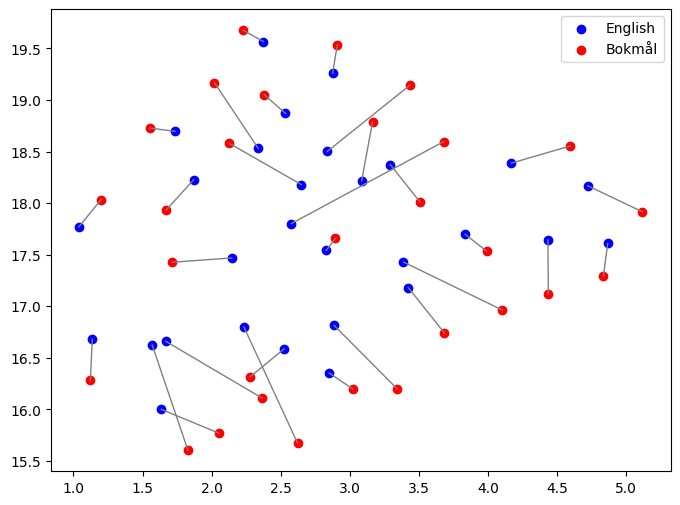

In [23]:
import umap
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
print(sourcesentences[2])
print(targetsentences[2])
source_embeds_vis = source_embeds[:30]
target_embeds_vis = target_embeds[:30]

# Convert and flatten tensors from the first set
data_set1 = np.array([tf.reshape(tensor, (-1,)).numpy() for tensor in source_embeds_vis])
labels_set1 = np.zeros(len(source_embeds_vis))

# Convert and flatten tensors from the second set
data_set2 = np.array([tf.reshape(tensor, (-1,)).numpy() for tensor in target_embeds_vis])
labels_set2 = np.ones(len(target_embeds_vis))


data = np.concatenate((data_set1, data_set2), axis=0)
labels = np.concatenate((labels_set1, labels_set2), axis=0)

# Apply UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(data)

# Visualize the Result
plt.figure(figsize=(8, 6))

# Scatter plot for Set 1
scatter_set1 = plt.scatter(embedding[labels == 0, 0], embedding[labels == 0, 1], label='Set 1', c='blue')

# Scatter plot for Set 2
scatter_set2 = plt.scatter(embedding[labels == 1, 0], embedding[labels == 1, 1], label='Set 2', c='red')

# Add lines connecting corresponding points
for i in range(len(source_embeds_vis)):
    line = Line2D([embedding[i, 0], embedding[i + len(source_embeds_vis), 0]],
                  [embedding[i, 1], embedding[i + len(source_embeds_vis), 1]],
                  linewidth=1, color='gray', alpha=1)
    plt.gca().add_line(line)

#plt.title('UMAP Visualization with Connections')
plt.legend(handles=[scatter_set1, scatter_set2], labels=['English', 'Bokmål'])
plt.show()

In [10]:
num = 51
print(pairs["en-nn"]["en"][num])
print(pairs["en-nn"]["nn"][num])


EMS from analyses of variance (LS) to estimate variances (g and r).
* EMS frå variansanalyse (LS) til å estimera variansar (g og r).
